# Learning Rate Finder 🔍

This notebook implements the Learning Rate Range Test (LR Finder) to help you find the optimal learning rate for training your ResNet50 model on ImageNet datasets.

## What is Learning Rate Finder?

The Learning Rate Finder is a technique that:
- **Systematically tests** different learning rates during training
- **Plots loss vs learning rate** to visualize the relationship
- **Identifies the optimal range** where loss decreases most rapidly
- **Prevents poor convergence** due to suboptimal learning rates

## Key Benefits:
- 🎯 **Find optimal LR** - Discover the best learning rate for your specific setup
- ⚡ **Faster convergence** - Start training with an ideal learning rate
- 📊 **Visual guidance** - Clear plots show the optimal range
- 🛡️ **Avoid pitfalls** - Prevent too high/low learning rates

## How to Use:
1. Update dataset path and model configuration
2. Run the learning rate finder
3. Analyze the loss vs LR plot
4. Choose the learning rate where loss decreases most steeply
5. Use this LR for your actual training

In [1]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import copy
import warnings
import sys
from pathlib import Path
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
parent_dir = Path('../').resolve()
sys.path.append(str(parent_dir))

# Import our custom modules
from imagenet_models import resnet50_imagenet
from imagenet_dataset import get_imagenet_transforms

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("📚 Libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name()}")

📚 Libraries imported successfully!
🔥 PyTorch version: 2.9.0+cu128
🖥️ CUDA available: True
🎮 GPU: Tesla T4


In [3]:
# Tiny ImageNet 200 Dataset Downloader and Setup
import os
import urllib.request
import zipfile
import shutil
from pathlib import Path

def download_tiny_imagenet():
    """
    Download and setup Tiny ImageNet 200 dataset
    Returns the path to the dataset directory
    """
    # Configuration
    dataset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    datasets_dir = Path("../datasets")
    dataset_name = "tiny-imagenet-200"
    dataset_path = datasets_dir / dataset_name
    zip_path = datasets_dir / "tiny-imagenet-200.zip"
    
    # Create datasets directory if it doesn't exist
    datasets_dir.mkdir(exist_ok=True)
    
    # Check if dataset already exists
    if dataset_path.exists() and (dataset_path / "train").exists():
        print(f"✅ Dataset already exists at: {dataset_path}")
        return str(dataset_path)
    
    print("📥 Downloading Tiny ImageNet 200 dataset...")
    print(f"   📍 URL: {dataset_url}")
    print(f"   📁 Destination: {dataset_path}")
    print(f"   💾 Size: ~237 MB")
    
    try:
        # Download with progress
        def show_progress(block_num, block_size, total_size):
            downloaded = block_num * block_size
            percent = min(100, (downloaded / total_size) * 100)
            bar_length = 50
            filled_length = int(bar_length * percent // 100)
            bar = '█' * filled_length + '-' * (bar_length - filled_length)
            print(f'\r📊 Progress: |{bar}| {percent:.1f}% ({downloaded//1024//1024}MB/{total_size//1024//1024}MB)', end='')
        
        urllib.request.urlretrieve(dataset_url, zip_path, show_progress)
        print("\n✅ Download completed!")
        
        # Extract the dataset
        print("📦 Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(datasets_dir)
        
        print("✅ Extraction completed!")
        
        # Clean up zip file
        os.remove(zip_path)
        print("🗑️ Cleaned up zip file")
        
        # Verify dataset structure
        train_dir = dataset_path / "train"
        val_dir = dataset_path / "val"
        test_dir = dataset_path / "test"
        
        if train_dir.exists() and val_dir.exists():
            num_train_classes = len(list(train_dir.iterdir()))
            print(f"✅ Dataset setup successful!")
            print(f"   📊 Training classes: {num_train_classes}")
            print(f"   📁 Train directory: {train_dir}")
            print(f"   📁 Validation directory: {val_dir}")
            print(f"   📁 Test directory: {test_dir}")
            
            # Count images
            train_images = sum(len(list((train_dir / class_dir).glob("*.JPEG"))) 
                             for class_dir in train_dir.iterdir() if class_dir.is_dir())
            print(f"   🖼️ Training images: {train_images:,}")
            
            return str(dataset_path)
        else:
            raise Exception("Dataset structure verification failed")
            
    except Exception as e:
        print(f"\n❌ Error downloading/extracting dataset: {e}")
        # Clean up on failure
        if zip_path.exists():
            os.remove(zip_path)
        if dataset_path.exists():
            shutil.rmtree(dataset_path)
        raise

def setup_tiny_imagenet_val_structure(dataset_path):
    """
    Reorganize Tiny ImageNet validation set to match training structure
    (validation images are originally in flat structure, need class folders)
    """
    dataset_path = Path(dataset_path)
    val_dir = dataset_path / "val"
    val_annotations = val_dir / "val_annotations.txt"
    val_images_dir = val_dir / "images"
    
    if not val_annotations.exists():
        print("⚠️ Validation annotations file not found. Skipping val restructure.")
        return
    
    print("🔧 Restructuring validation directory...")
    
    # Read validation annotations
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                img_name, class_id = parts[0], parts[1]
                val_dict[img_name] = class_id
    
    # Create class directories and move images
    moved_count = 0
    for img_name, class_id in val_dict.items():
        # Create class directory if it doesn't exist
        class_dir = val_dir / class_id
        class_dir.mkdir(exist_ok=True)
        
        # Move image from images/ to class_id/
        src_path = val_images_dir / img_name
        dst_path = class_dir / img_name
        
        if src_path.exists() and not dst_path.exists():
            shutil.move(str(src_path), str(dst_path))
            moved_count += 1
    
    # Remove empty images directory
    if val_images_dir.exists() and not any(val_images_dir.iterdir()):
        val_images_dir.rmdir()
    
    print(f"✅ Moved {moved_count} validation images to class folders")

# Download and setup the dataset
try:
    print("🚀 Setting up Tiny ImageNet 200 dataset...")
    dataset_path = download_tiny_imagenet()
    setup_tiny_imagenet_val_structure(dataset_path)
    
    print(f"\n🎉 Dataset ready for use!")
    print(f"📁 Dataset location: {dataset_path}")
    print(f"\n💡 Dataset Information:")
    print(f"   • 200 classes (subset of ImageNet)")
    print(f"   • 64x64 pixel images")
    print(f"   • 500 training images per class (100,000 total)")
    print(f"   • 50 validation images per class (10,000 total)")
    print(f"   • 50 test images per class (10,000 total)")
    
    # Update the configuration in the next cell
    print(f"\n🔧 The IMAGENET_ROOT path will be automatically updated!")
    
except Exception as e:
    print(f"❌ Failed to setup dataset: {e}")
    print("\n💡 Alternative options:")
    print("   1. Manually download from: http://cs231n.stanford.edu/tiny-imagenet-200.zip")
    print("   2. Use a different dataset (ImageNette, ImageWoof)")
    print("   3. Check your internet connection and try again")

🚀 Setting up Tiny ImageNet 200 dataset...
📥 Downloading Tiny ImageNet 200 dataset...
   📍 URL: http://cs231n.stanford.edu/tiny-imagenet-200.zip
   📁 Destination: ../datasets/tiny-imagenet-200
   💾 Size: ~237 MB
📊 Progress: |██████████████████████████████████████████████████| 100.0% (236MB/236MB)
✅ Download completed!
📦 Extracting dataset...
📊 Progress: |██████████████████████████████████████████████████| 100.0% (236MB/236MB)
✅ Download completed!
📦 Extracting dataset...
✅ Extraction completed!
🗑️ Cleaned up zip file
✅ Dataset setup successful!
   📊 Training classes: 200
   📁 Train directory: ../datasets/tiny-imagenet-200/train
   📁 Validation directory: ../datasets/tiny-imagenet-200/val
   📁 Test directory: ../datasets/tiny-imagenet-200/test
   🖼️ Training images: 0
🔧 Restructuring validation directory...
✅ Extraction completed!
🗑️ Cleaned up zip file
✅ Dataset setup successful!
   📊 Training classes: 200
   📁 Train directory: ../datasets/tiny-imagenet-200/train
   📁 Validation directo

In [13]:
# Configuration and Setup
# Auto-detect or use downloaded Tiny ImageNet dataset
datasets_dir = Path("../datasets")
tiny_imagenet_path = datasets_dir / "tiny-imagenet-200"

if tiny_imagenet_path.exists():
    IMAGENET_ROOT = str(tiny_imagenet_path)
    print(f"✅ Using downloaded Tiny ImageNet: {IMAGENET_ROOT}")
else:
    IMAGENET_ROOT = "../datasets/tiny-imagenet-200"  # Default path
    print(f"⚠️ Dataset not found. Will use default path: {IMAGENET_ROOT}")

TRAIN_DIR = str(Path(IMAGENET_ROOT) / "train")
VAL_DIR = str(Path(IMAGENET_ROOT) / "val")

# Check if dataset exists, if not suggest downloading
if not Path(IMAGENET_ROOT).exists():
    print("❌ Dataset not found at default location!")
    print("\n💡 Options:")
    print("   1. Run the dataset downloader cell above (Cell 4)")
    print("   2. Manually download and extract to ../datasets/")
    print("   3. Update IMAGENET_ROOT to point to your dataset")
    
    print("\n📁 Available datasets:")
    if datasets_dir.exists():
        for dataset_path in datasets_dir.iterdir():
            if dataset_path.is_dir():
                print(f"   • {dataset_path.name}")
    else:
        print("   📥 No datasets found in ../datasets/")
else:
    print(f"✅ Dataset found: {IMAGENET_ROOT}")
    
    # Verify dataset structure
    train_path = Path(TRAIN_DIR)
    val_path = Path(VAL_DIR)
    
    if train_path.exists():
        num_classes = len([d for d in train_path.iterdir() if d.is_dir()])
        print(f"   📊 Training classes detected: {num_classes}")
    
    if val_path.exists():
        val_classes = len([d for d in val_path.iterdir() if d.is_dir()])
        print(f"   📊 Validation classes detected: {val_classes}")

# Learning Rate Finder Configuration
LR_FINDER_CONFIG = {
    'min_lr': 1e-7,           # Minimum learning rate to test
    'max_lr': 10.0,           # Maximum learning rate to test
    'num_iterations': 100,    # Number of iterations to run
    'beta': 0.98,             # Smoothing factor for loss
    'stop_div_factor': 5,     # Stop if loss increases by this factor
    'batch_size': 128,        # Batch size for LR finder
    'num_workers': 4,         # Number of data loading workers
    'subset_size': 5000,      # Use subset of data for faster testing
}

# Auto-detect dataset type and adjust configuration based on actual dataset
print(f"\n🔍 Detecting dataset type from path: {IMAGENET_ROOT}")

if "tiny-imagenet" in IMAGENET_ROOT.lower() or "tiny_imagenet" in IMAGENET_ROOT.lower():
    MODEL_CONFIG = {
        'model_name': 'resnet50',
        'num_classes': 200,       # Tiny ImageNet has 200 classes
        'pretrained': False,      # No pretrained for Tiny ImageNet
        'input_size': 64,         # 64x64 images
    }
    LR_FINDER_CONFIG['batch_size'] = 256  # Can use larger batch for smaller images
    print("🎯 Configured for Tiny ImageNet (200 classes, 64x64 images)")
elif "imagenette" in IMAGENET_ROOT.lower() or "imagewoof" in IMAGENET_ROOT.lower():
    MODEL_CONFIG = {
        'model_name': 'resnet50',
        'num_classes': 10,        # Imagenette/ImageWoof have 10 classes
        'pretrained': True,       # Pretrained recommended for smaller datasets
        'input_size': 224,        # Standard ImageNet size
    }
    print("🎯 Configured for Imagenette/ImageWoof (10 classes, 224x224 images)")
else:
    # Check actual number of classes if dataset exists
    if Path(TRAIN_DIR).exists():
        actual_classes = len([d for d in Path(TRAIN_DIR).iterdir() if d.is_dir()])
        print(f"📊 Detected {actual_classes} classes in training directory")
        
        if actual_classes == 200:
            MODEL_CONFIG = {
                'model_name': 'resnet50',
                'num_classes': 200,
                'pretrained': False,
                'input_size': 64,  # Assume Tiny ImageNet format
            }
            LR_FINDER_CONFIG['batch_size'] = 256
            print("🎯 Configured for Tiny ImageNet based on class count (200 classes, 64x64 images)")
        elif actual_classes == 10:
            MODEL_CONFIG = {
                'model_name': 'resnet50',
                'num_classes': 10,
                'pretrained': True,
                'input_size': 224,
            }
            print("🎯 Configured for small dataset (10 classes, 224x224 images)")
        else:
            # Default to full ImageNet configuration
            MODEL_CONFIG = {
                'model_name': 'resnet50',
                'num_classes': actual_classes,
                'pretrained': False,
                'input_size': 224,
            }
            print(f"🎯 Configured for custom dataset ({actual_classes} classes, 224x224 images)")
    else:
        # Fallback configuration
        MODEL_CONFIG = {
            'model_name': 'resnet50',
            'num_classes': 1000,      # Full ImageNet classes
            'pretrained': False,      # Set to True if you want pretrained weights
            'input_size': 224,        # Standard ImageNet size
        }
        print("🎯 Using fallback configuration (1000 classes, 224x224 images)")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Using device: {device}")

if device.type == 'cpu':
    print("⚠️ Warning: Using CPU. LR finder will be slow.")
    LR_FINDER_CONFIG['batch_size'] = 32  # Smaller batch for CPU
    LR_FINDER_CONFIG['subset_size'] = 1000  # Smaller subset for CPU

print("\n📋 LR Finder Configuration:")
for key, value in LR_FINDER_CONFIG.items():
    print(f"   {key}: {value}")

print(f"\n🏗️ Model Configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"   {key}: {value}")

✅ Using downloaded Tiny ImageNet: ../datasets/tiny-imagenet-200
✅ Dataset found: ../datasets/tiny-imagenet-200
   📊 Training classes detected: 200
   📊 Validation classes detected: 200

🔍 Detecting dataset type from path: ../datasets/tiny-imagenet-200
🎯 Configured for Tiny ImageNet (200 classes, 64x64 images)

🖥️ Using device: cuda

📋 LR Finder Configuration:
   min_lr: 1e-07
   max_lr: 10.0
   num_iterations: 100
   beta: 0.98
   stop_div_factor: 5
   batch_size: 256
   num_workers: 4
   subset_size: 5000

🏗️ Model Configuration:
   model_name: resnet50
   num_classes: 200
   pretrained: False
   input_size: 64


In [14]:
class LearningRateFinder:
    """Learning Rate Range Test Implementation"""
    
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        
        # Store initial model and optimizer state
        self.model_state = copy.deepcopy(model.state_dict())
        self.optimizer_state = copy.deepcopy(optimizer.state_dict())
        
        # Results storage
        self.learning_rates = []
        self.losses = []
        
    def reset(self):
        """Reset model and optimizer to initial state"""
        self.model.load_state_dict(self.model_state)
        self.optimizer.load_state_dict(self.optimizer_state)
        self.learning_rates = []
        self.losses = []
    
    def find_lr(self, train_loader, min_lr=1e-7, max_lr=10.0, num_iterations=100, 
                beta=0.98, stop_div_factor=5):
        """Perform learning rate range test"""
        
        print(f"🔍 Starting Learning Rate Finder...")
        print(f"   📊 LR range: {min_lr:.2e} to {max_lr:.2e}")
        print(f"   🔄 Iterations: {num_iterations}")
        
        # Reset to initial state
        self.reset()
        
        # Calculate learning rate schedule
        lr_schedule = np.logspace(np.log10(min_lr), np.log10(max_lr), num_iterations)
        
        # Training setup
        self.model.train()
        data_iter = iter(train_loader)
        
        # Initialize tracking variables
        smoothed_loss = 0
        best_loss = float('inf')
        
        # Progress bar
        pbar = tqdm(enumerate(lr_schedule), total=num_iterations, desc="LR Finder")
        
        for i, lr in pbar:
            # Update learning rate
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
            
            # Get next batch (cycle through dataset if needed)
            try:
                inputs, targets = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                inputs, targets = next(data_iter)
            
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Track loss
            current_loss = loss.item()
            
            # Smooth loss for better visualization
            if i == 0:
                smoothed_loss = current_loss
            else:
                smoothed_loss = beta * smoothed_loss + (1 - beta) * current_loss
            
            # Store values
            self.learning_rates.append(lr)
            self.losses.append(smoothed_loss)
            
            # Update progress bar
            pbar.set_postfix({
                'LR': f'{lr:.2e}',
                'Loss': f'{smoothed_loss:.4f}'
            })
            
            # Early stopping if loss explodes
            if i > 0 and smoothed_loss > stop_div_factor * best_loss:
                print(f"\n🛑 Stopping early at iteration {i}: loss exploded!")
                break
            
            # Track best loss
            if smoothed_loss < best_loss:
                best_loss = smoothed_loss
        
        pbar.close()
        print(f"✅ Learning rate finder completed!")
        print(f"   📊 Tested {len(self.learning_rates)} learning rates")
        print(f"   📉 Best loss: {best_loss:.4f}")
        
        return self.learning_rates, self.losses
    
    def plot_results(self, skip_start=10, skip_end=5, suggest_lr=True):
        """Plot learning rate vs loss with suggestions"""
        
        if len(self.learning_rates) == 0:
            print("❌ No results to plot. Run find_lr() first!")
            return
        
        # Skip noisy start and end portions
        start_idx = skip_start
        end_idx = len(self.learning_rates) - skip_end
        
        lr_plot = self.learning_rates[start_idx:end_idx]
        loss_plot = self.losses[start_idx:end_idx]
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        
        # Main plot
        plt.subplot(2, 1, 1)
        plt.semilogx(lr_plot, loss_plot, 'b-', linewidth=2, label='Loss vs LR')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder Results', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Suggest optimal learning rate
        if suggest_lr and len(loss_plot) > 10:
            # Find steepest descent (negative gradient)
            gradients = np.gradient(loss_plot)
            min_gradient_idx = np.argmin(gradients)
            suggested_lr = lr_plot[min_gradient_idx]
            
            # Also find minimum loss point for reference
            min_loss_idx = np.argmin(loss_plot)
            min_loss_lr = lr_plot[min_loss_idx]
            
            # Plot suggestions
            plt.axvline(suggested_lr, color='red', linestyle='--', alpha=0.8, 
                       label=f'Suggested LR: {suggested_lr:.2e}')
            plt.axvline(min_loss_lr, color='green', linestyle='--', alpha=0.8,
                       label=f'Min Loss LR: {min_loss_lr:.2e}')
            
            # Conservative suggestion (1/10 of steepest point)
            conservative_lr = suggested_lr / 10
            plt.axvline(conservative_lr, color='orange', linestyle='--', alpha=0.8,
                       label=f'Conservative LR: {conservative_lr:.2e}')
        
        plt.legend()
        
        # Gradient plot
        plt.subplot(2, 1, 2)
        if len(loss_plot) > 1:
            gradients = np.gradient(loss_plot)
            plt.semilogx(lr_plot, gradients, 'r-', linewidth=2, label='Loss Gradient')
            plt.axhline(0, color='black', linestyle='-', alpha=0.3)
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss Gradient')
            plt.title('Loss Gradient (Choose LR where gradient is most negative)')
            plt.grid(True, alpha=0.3)
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print recommendations
        if suggest_lr and len(loss_plot) > 10:
            print("\n🎯 Learning Rate Recommendations:")
            print(f"   🔴 Steepest descent: {suggested_lr:.2e} (where loss decreases fastest)")
            print(f"   🟢 Minimum loss: {min_loss_lr:.2e} (lowest loss achieved)")
            print(f"   🟠 Conservative: {conservative_lr:.2e} (safer choice, 1/10 of steepest)")
            print("\n💡 Recommended approach:")
            print(f"   • Start with conservative LR: {conservative_lr:.2e}")
            print(f"   • If training is stable, try steepest: {suggested_lr:.2e}")
            print(f"   • Monitor loss and adjust as needed")
    
    def export_results(self, filename='lr_finder_results.txt'):
        """Export results to file"""
        with open(filename, 'w') as f:
            f.write("Learning Rate Finder Results\n")
            f.write("===========================\n\n")
            for lr, loss in zip(self.learning_rates, self.losses):
                f.write(f"{lr:.6e}\t{loss:.6f}\n")
        print(f"📄 Results exported to {filename}")

print("🏗️ LearningRateFinder class defined successfully!")

🏗️ LearningRateFinder class defined successfully!


In [15]:
# Prepare Dataset and DataLoader
print("📊 Preparing dataset...")

# Get transforms based on input size
if MODEL_CONFIG['input_size'] == 64:
    # Tiny ImageNet transforms
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    # Standard ImageNet transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load dataset
try:
    train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_DIR,
        transform=transform
    )
    
    print(f"✅ Dataset loaded successfully!")
    print(f"   📊 Total samples: {len(train_dataset):,}")
    print(f"   🏷️ Number of classes: {len(train_dataset.classes)}")
    
    # Create subset for faster LR finding
    subset_size = min(LR_FINDER_CONFIG['subset_size'], len(train_dataset))
    subset_indices = torch.randperm(len(train_dataset))[:subset_size]
    train_subset = Subset(train_dataset, subset_indices)
    
    print(f"   🎯 Using subset: {len(train_subset):,} samples")
    
    # Create DataLoader
    train_loader = DataLoader(
        train_subset,
        batch_size=LR_FINDER_CONFIG['batch_size'],
        shuffle=True,
        num_workers=LR_FINDER_CONFIG['num_workers'],
        pin_memory=True if device.type == 'cuda' else False
    )
    
    print(f"   📦 Batch size: {LR_FINDER_CONFIG['batch_size']}")
    print(f"   🔄 Number of batches: {len(train_loader)}")
    
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("\n💡 Troubleshooting:")
    print("   1. Check if dataset path is correct")
    print("   2. Ensure dataset has train/ subdirectory")
    print("   3. Verify dataset structure (train/class_name/images.jpg)")
    print("   4. Download dataset using: ../dataset_tools/imagenet_subset_downloader.ipynb")
    raise

📊 Preparing dataset...
✅ Dataset loaded successfully!
   📊 Total samples: 100,000
   🏷️ Number of classes: 200
   🎯 Using subset: 5,000 samples
   📦 Batch size: 256
   🔄 Number of batches: 20
✅ Dataset loaded successfully!
   📊 Total samples: 100,000
   🏷️ Number of classes: 200
   🎯 Using subset: 5,000 samples
   📦 Batch size: 256
   🔄 Number of batches: 20


In [16]:
# Initialize Model, Optimizer, and Loss Function
print("🏗️ Initializing model...")

# Create model
model = resnet50_imagenet(
    num_classes=MODEL_CONFIG['num_classes'],
    pretrained=MODEL_CONFIG['pretrained']
)
model = model.to(device)

print(f"✅ Model created: {MODEL_CONFIG['model_name']}")
print(f"   🎯 Classes: {MODEL_CONFIG['num_classes']}")
print(f"   🔄 Pretrained: {MODEL_CONFIG['pretrained']}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   📊 Total parameters: {total_params:,}")
print(f"   🎓 Trainable parameters: {trainable_params:,}")

# Initialize optimizer (SGD is commonly used for LR finding)
optimizer = optim.SGD(
    model.parameters(),
    lr=LR_FINDER_CONFIG['min_lr'],  # Will be updated during LR finding
    momentum=0.9,
    weight_decay=1e-4
)

# Loss function
criterion = nn.CrossEntropyLoss()

print(f"✅ Optimizer: SGD with momentum=0.9, weight_decay=1e-4")
print(f"✅ Loss function: CrossEntropyLoss")

# Test forward pass
model.eval()
with torch.no_grad():
    try:
        # Create dummy input based on input size
        dummy_input = torch.randn(2, 3, MODEL_CONFIG['input_size'], MODEL_CONFIG['input_size']).to(device)
        dummy_output = model(dummy_input)
        print(f"✅ Forward pass test successful!")
        print(f"   📊 Input shape: {dummy_input.shape}")
        print(f"   📊 Output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"❌ Forward pass test failed: {e}")
        raise

model.train()  # Set back to training mode
print("\n🚀 Ready for learning rate finding!")

🏗️ Initializing model...
✅ Model created: resnet50
   🎯 Classes: 200
   🔄 Pretrained: False
   📊 Total parameters: 23,917,832
   🎓 Trainable parameters: 23,917,832
✅ Optimizer: SGD with momentum=0.9, weight_decay=1e-4
✅ Loss function: CrossEntropyLoss
✅ Forward pass test successful!
   📊 Input shape: torch.Size([2, 3, 64, 64])
   📊 Output shape: torch.Size([2, 200])

🚀 Ready for learning rate finding!
✅ Model created: resnet50
   🎯 Classes: 200
   🔄 Pretrained: False
   📊 Total parameters: 23,917,832
   🎓 Trainable parameters: 23,917,832
✅ Optimizer: SGD with momentum=0.9, weight_decay=1e-4
✅ Loss function: CrossEntropyLoss
✅ Forward pass test successful!
   📊 Input shape: torch.Size([2, 3, 64, 64])
   📊 Output shape: torch.Size([2, 200])

🚀 Ready for learning rate finding!


In [17]:
# Run Learning Rate Finder
print("🔍 Running Learning Rate Finder...")
print("" * 50)

# Create LR Finder instance
lr_finder = LearningRateFinder(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device
)

# Run the learning rate range test
learning_rates, losses = lr_finder.find_lr(
    train_loader=train_loader,
    min_lr=LR_FINDER_CONFIG['min_lr'],
    max_lr=LR_FINDER_CONFIG['max_lr'],
    num_iterations=LR_FINDER_CONFIG['num_iterations'],
    beta=LR_FINDER_CONFIG['beta'],
    stop_div_factor=LR_FINDER_CONFIG['stop_div_factor']
)

print("\n" + "=" * 50)
print("🎉 Learning Rate Finder completed!")
print(f"📊 Tested {len(learning_rates)} learning rates")
print(f"📉 Loss range: {min(losses):.4f} to {max(losses):.4f}")

🔍 Running Learning Rate Finder...

🔍 Starting Learning Rate Finder...
   📊 LR range: 1.00e-07 to 1.00e+01
   🔄 Iterations: 100


LR Finder: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s, LR=1.00e+01, Loss=6.2051]

✅ Learning rate finder completed!
   📊 Tested 100 learning rates
   📉 Best loss: 5.5044

🎉 Learning Rate Finder completed!
📊 Tested 100 learning rates
📉 Loss range: 5.5044 to 6.3229


📊 Plotting results and analyzing optimal learning rate...


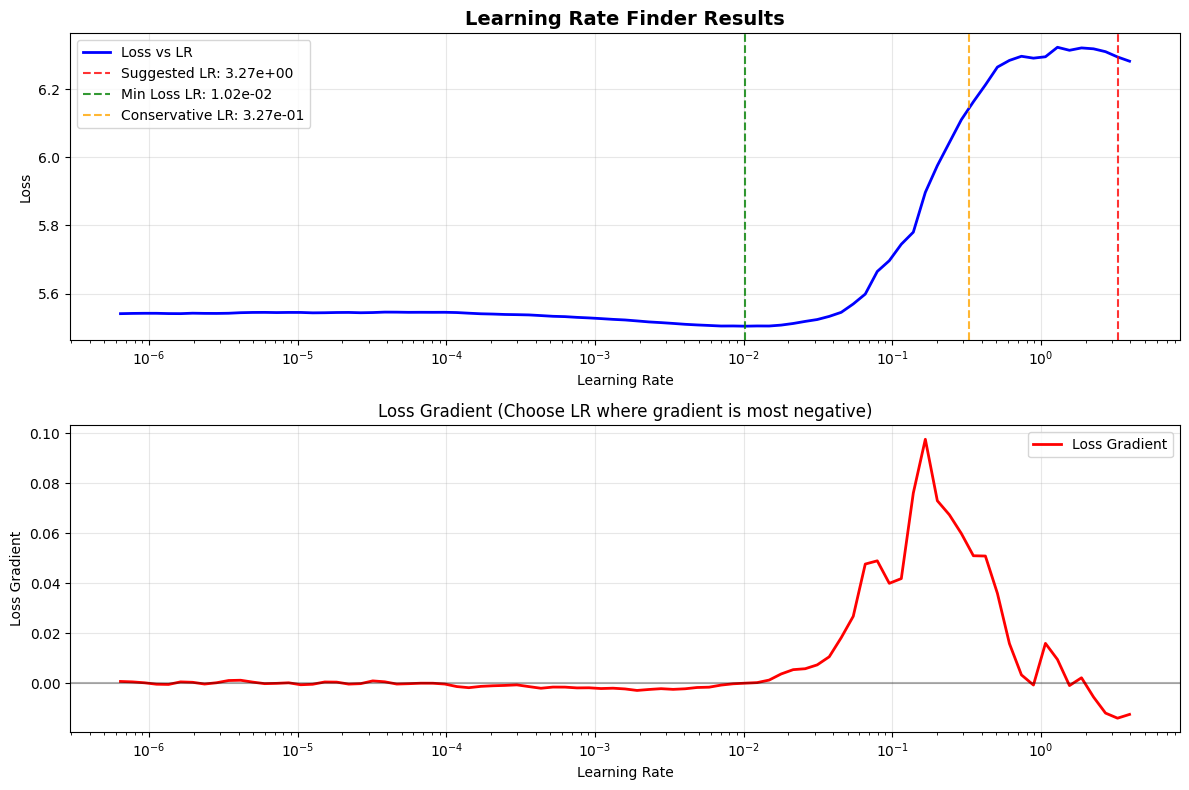


🎯 Learning Rate Recommendations:
   🔴 Steepest descent: 3.27e+00 (where loss decreases fastest)
   🟢 Minimum loss: 1.02e-02 (lowest loss achieved)
   🟠 Conservative: 3.27e-01 (safer choice, 1/10 of steepest)

💡 Recommended approach:
   • Start with conservative LR: 3.27e-01
   • If training is stable, try steepest: 3.27e+00
   • Monitor loss and adjust as needed


In [18]:
# Plot and Analyze Results
print("📊 Plotting results and analyzing optimal learning rate...")

# Plot the results with suggestions
lr_finder.plot_results(
    skip_start=10,    # Skip first 10 points (usually noisy)
    skip_end=5,       # Skip last 5 points (usually diverged)
    suggest_lr=True   # Show suggested learning rates
)

In [19]:
# Advanced Analysis and Export
print("🔬 Advanced Analysis")
print("=" * 30)

if len(learning_rates) > 20:
    # Skip noisy portions for analysis
    start_idx = 10
    end_idx = len(learning_rates) - 5
    lr_analysis = learning_rates[start_idx:end_idx]
    loss_analysis = losses[start_idx:end_idx]
    
    # Find key points
    min_loss_idx = np.argmin(loss_analysis)
    min_loss_lr = lr_analysis[min_loss_idx]
    min_loss = loss_analysis[min_loss_idx]
    
    # Calculate gradients for steepest descent
    gradients = np.gradient(loss_analysis)
    steepest_idx = np.argmin(gradients)
    steepest_lr = lr_analysis[steepest_idx]
    
    # Loss reduction analysis
    initial_loss = loss_analysis[0]
    max_reduction = initial_loss - min_loss
    reduction_percent = (max_reduction / initial_loss) * 100
    
    print(f"📊 Analysis Summary:")
    print(f"   🔴 Steepest descent LR: {steepest_lr:.2e}")
    print(f"   🟢 Minimum loss LR: {min_loss_lr:.2e}")
    print(f"   📉 Best loss achieved: {min_loss:.4f}")
    print(f"   📈 Initial loss: {initial_loss:.4f}")
    print(f"   🎯 Loss reduction: {reduction_percent:.1f}%")
    
    # Practical recommendations
    conservative_lr = steepest_lr / 10
    aggressive_lr = steepest_lr * 2
    
    print(f"\n💡 Training Recommendations:")
    print(f"   🟠 Conservative start: {conservative_lr:.2e}")
    print(f"   🔴 Optimal range: {steepest_lr:.2e}")
    print(f"   🔥 Aggressive (risky): {aggressive_lr:.2e}")
    
    # Dataset-specific advice
    if MODEL_CONFIG['num_classes'] <= 10:
        print(f"\n🎯 For small datasets ({MODEL_CONFIG['num_classes']} classes):")
        print(f"   • Start conservative: {conservative_lr:.2e}")
        print(f"   • Use learning rate scheduling")
        print(f"   • Consider pretrained weights")
    elif MODEL_CONFIG['num_classes'] == 200:
        print(f"\n🎯 For Tiny ImageNet (200 classes):")
        print(f"   • Good starting LR: {steepest_lr:.2e}")
        print(f"   • Use step or cosine LR scheduling")
        print(f"   • Train for 50-100 epochs")
    else:
        print(f"\n🎯 For large datasets ({MODEL_CONFIG['num_classes']} classes):")
        print(f"   • Start with: {conservative_lr:.2e}")
        print(f"   • Gradually increase if stable")
        print(f"   • Use warmup for first few epochs")
    
    # Export results
    lr_finder.export_results('lr_finder_results.csv')
    
    print(f"\n📄 Results exported to lr_finder_results.csv")
    print(f"\n🚀 Ready to start training with optimal learning rate!")
    
else:
    print("⚠️ Not enough data points for detailed analysis")
    print("Consider increasing num_iterations in configuration")

🔬 Advanced Analysis
📊 Analysis Summary:
   🔴 Steepest descent LR: 3.27e+00
   🟢 Minimum loss LR: 1.02e-02
   📉 Best loss achieved: 5.5044
   📈 Initial loss: 5.5411
   🎯 Loss reduction: 0.7%

💡 Training Recommendations:
   🟠 Conservative start: 3.27e-01
   🔴 Optimal range: 3.27e+00
   🔥 Aggressive (risky): 6.55e+00

🎯 For Tiny ImageNet (200 classes):
   • Good starting LR: 3.27e+00
   • Use step or cosine LR scheduling
   • Train for 50-100 epochs
📄 Results exported to lr_finder_results.csv

📄 Results exported to lr_finder_results.csv

🚀 Ready to start training with optimal learning rate!


🎮 Interactive Learning Rate Selection Tool
📋 Instructions:
   • Click on any point in the top-left plot to select learning rates
   • Selected points will be highlighted with red circles
   • Values will be printed below the plot
   • Use this to identify optimal learning rate ranges


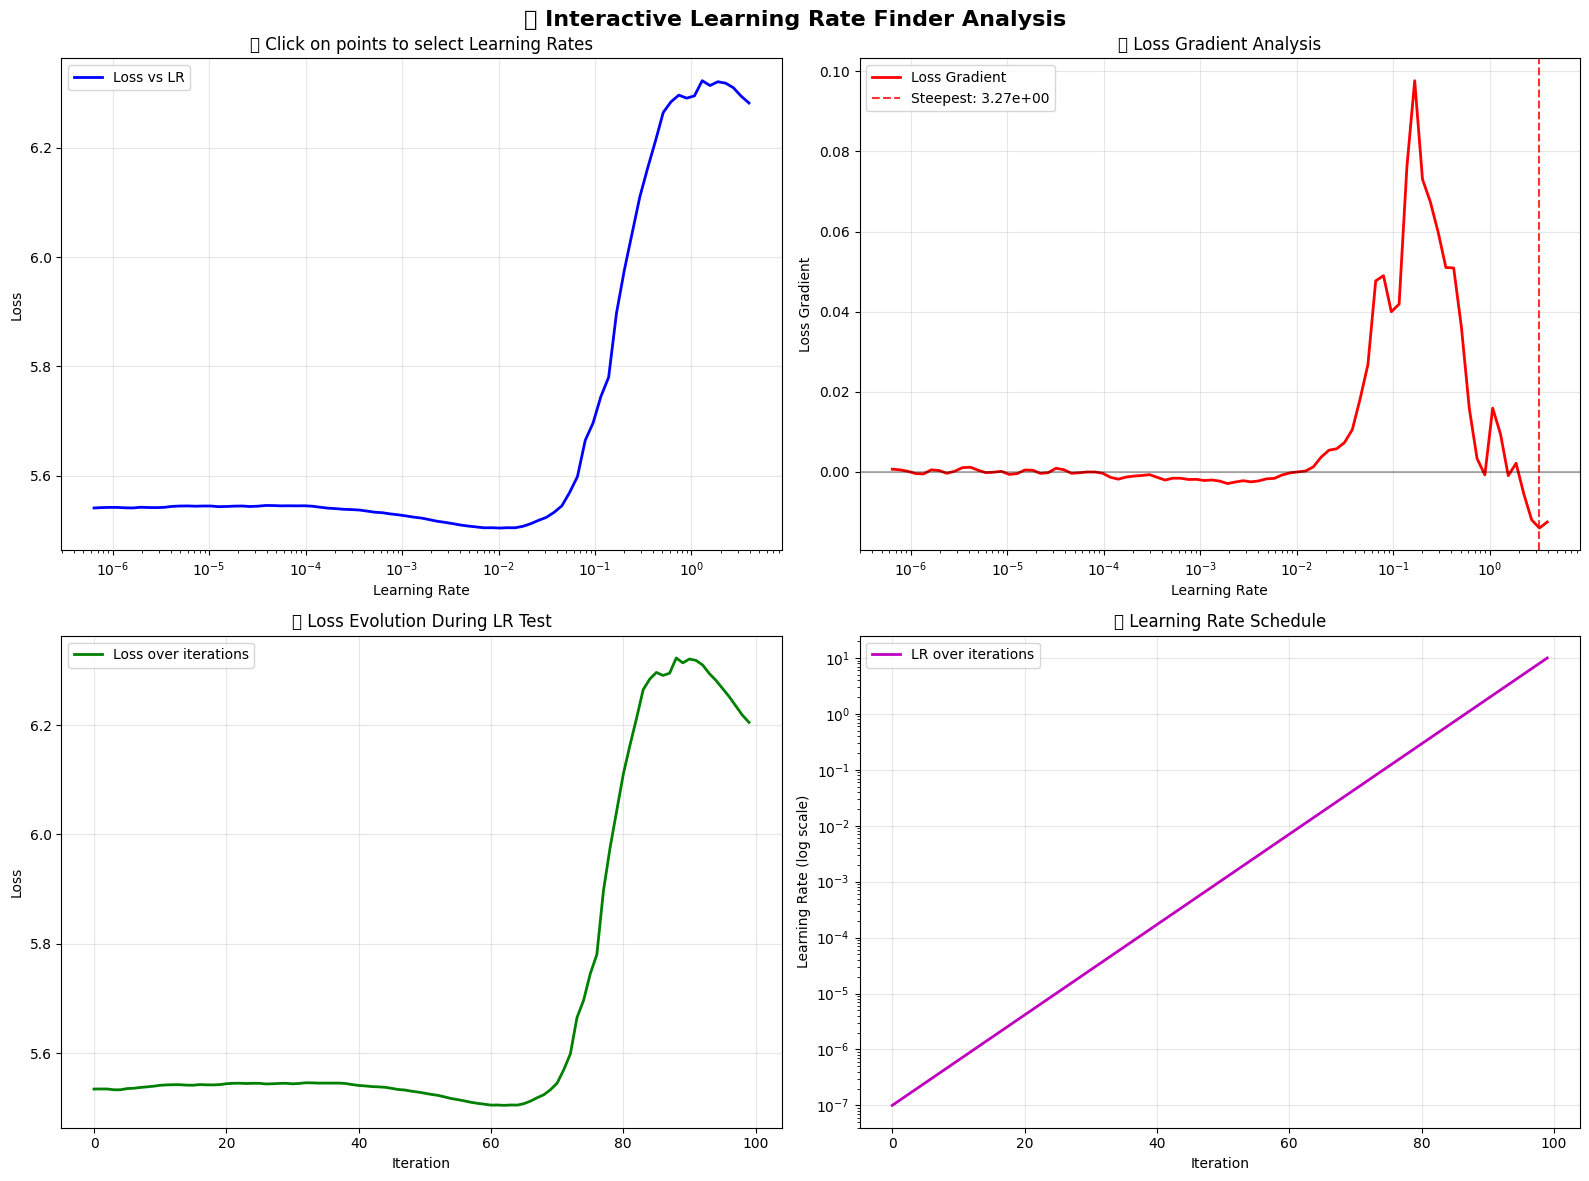


📊 Learning Rate Range Analysis:
   🔹 Minimum LR tested: 1.00e-07
   🔹 Maximum LR tested: 1.00e+01
   🔹 Range span: 1.0e+08x
   🔹 Total points tested: 100

🎯 Key Learning Rate Points:
   🟢 Minimum loss LR: 1.023531e-02 (Loss: 5.5044)
   🔴 Steepest descent LR: 3.274549e+00
   🟠 Conservative choice: 3.274549e-01


In [20]:
# Interactive Learning Rate Selection and Analysis
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np

class InteractiveLRPlotter:
    def __init__(self, learning_rates, losses, skip_start=10, skip_end=5):
        self.learning_rates = learning_rates
        self.losses = losses
        self.skip_start = skip_start
        self.skip_end = skip_end
        
        # Skip noisy portions
        start_idx = skip_start
        end_idx = len(learning_rates) - skip_end
        self.lr_plot = learning_rates[start_idx:end_idx]
        self.loss_plot = losses[start_idx:end_idx]
        
        self.selected_points = []
        self.selected_lrs = []
        
    def plot_interactive(self):
        """Create interactive plot with click selection"""
        
        # Create figure with multiple subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('📊 Interactive Learning Rate Finder Analysis', fontsize=16, fontweight='bold')
        
        # Main Loss vs LR plot (top-left)
        ax1.semilogx(self.lr_plot, self.loss_plot, 'b-', linewidth=2, label='Loss vs LR', picker=True, pickradius=5)
        ax1.set_xlabel('Learning Rate')
        ax1.set_ylabel('Loss')
        ax1.set_title('🎯 Click on points to select Learning Rates')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Add cursor for better interaction
        cursor1 = Cursor(ax1, useblit=True, color='red', linewidth=1)
        
        # Gradient plot (top-right)
        if len(self.loss_plot) > 1:
            gradients = np.gradient(self.loss_plot)
            ax2.semilogx(self.lr_plot, gradients, 'r-', linewidth=2, label='Loss Gradient')
            ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
            ax2.set_xlabel('Learning Rate')
            ax2.set_ylabel('Loss Gradient')
            ax2.set_title('📈 Loss Gradient Analysis')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            
            # Mark steepest descent point
            min_gradient_idx = np.argmin(gradients)
            steepest_lr = self.lr_plot[min_gradient_idx]
            ax2.axvline(steepest_lr, color='red', linestyle='--', alpha=0.8, 
                       label=f'Steepest: {steepest_lr:.2e}')
            ax2.legend()
        
        # Loss vs Iteration (bottom-left)
        iterations = range(len(self.losses))
        ax3.plot(iterations, self.losses, 'g-', linewidth=2, label='Loss over iterations')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.set_title('📉 Loss Evolution During LR Test')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # LR vs Iteration (bottom-right)
        ax4.semilogy(iterations, self.learning_rates, 'm-', linewidth=2, label='LR over iterations')
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Learning Rate (log scale)')
        ax4.set_title('🔄 Learning Rate Schedule')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        # Store axes for click handler
        self.fig = fig
        self.ax1 = ax1
        self.ax2 = ax2
        
        # Connect click event
        self.cid = fig.canvas.mpl_connect('button_press_event', self.on_click)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def on_click(self, event):
        """Handle mouse click events to select LR points"""
        if event.inaxes == self.ax1 and event.button == 1:  # Left click on main plot
            # Find closest point
            if len(self.lr_plot) > 0:
                # Convert click coordinates
                x_click = event.xdata
                y_click = event.ydata
                
                if x_click is not None and y_click is not None:
                    # Find closest LR point
                    log_distances = np.abs(np.log10(self.lr_plot) - np.log10(x_click))
                    closest_idx = np.argmin(log_distances)
                    
                    selected_lr = self.lr_plot[closest_idx]
                    selected_loss = self.loss_plot[closest_idx]
                    
                    # Add to selections
                    self.selected_lrs.append(selected_lr)
                    
                    # Plot the selected point
                    self.ax1.plot(selected_lr, selected_loss, 'ro', markersize=8, 
                                 markeredgecolor='black', markeredgewidth=2)
                    
                    # Add annotation
                    self.ax1.annotate(f'LR: {selected_lr:.2e}\nLoss: {selected_loss:.4f}',
                                     xy=(selected_lr, selected_loss),
                                     xytext=(20, 20), textcoords='offset points',
                                     bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
                    
                    # Update plot
                    self.fig.canvas.draw()
                    
                    # Print selection info
                    print(f"\n🎯 Selected Point #{len(self.selected_lrs)}:")
                    print(f"   📊 Learning Rate: {selected_lr:.6e}")
                    print(f"   📉 Loss Value: {selected_loss:.6f}")
                    
                    # Print comparison with suggestions if we have enough data
                    if len(self.loss_plot) > 10:
                        gradients = np.gradient(self.loss_plot)
                        min_gradient_idx = np.argmin(gradients)
                        suggested_lr = self.lr_plot[min_gradient_idx]
                        min_loss_idx = np.argmin(self.loss_plot)
                        min_loss_lr = self.lr_plot[min_loss_idx]
                        
                        print(f"   🔴 Compared to suggested (steepest): {suggested_lr:.6e}")
                        print(f"   🟢 Compared to minimum loss: {min_loss_lr:.6e}")
                        
                        if selected_lr > suggested_lr * 2:
                            print(f"   ⚠️  Your selection is quite high - consider a lower LR")
                        elif selected_lr < suggested_lr / 100:
                            print(f"   ⚠️  Your selection is quite low - might be too conservative")
                        else:
                            print(f"   ✅ Your selection is in a reasonable range")
    
    def get_lr_range_analysis(self):
        """Analyze the full range of learning rates tested"""
        if len(self.learning_rates) == 0:
            print("❌ No learning rate data available")
            return
            
        min_lr = min(self.learning_rates)
        max_lr = max(self.learning_rates)
        
        print(f"\n📊 Learning Rate Range Analysis:")
        print(f"   🔹 Minimum LR tested: {min_lr:.2e}")
        print(f"   🔹 Maximum LR tested: {max_lr:.2e}")
        print(f"   🔹 Range span: {max_lr/min_lr:.1e}x")
        print(f"   🔹 Total points tested: {len(self.learning_rates)}")
        
        # Find key statistics
        if len(self.loss_plot) > 10:
            min_loss_idx = np.argmin(self.loss_plot)
            min_loss_lr = self.lr_plot[min_loss_idx]
            min_loss_val = self.loss_plot[min_loss_idx]
            
            gradients = np.gradient(self.loss_plot)
            steepest_idx = np.argmin(gradients)
            steepest_lr = self.lr_plot[steepest_idx]
            
            print(f"\n🎯 Key Learning Rate Points:")
            print(f"   🟢 Minimum loss LR: {min_loss_lr:.6e} (Loss: {min_loss_val:.4f})")
            print(f"   🔴 Steepest descent LR: {steepest_lr:.6e}")
            print(f"   🟠 Conservative choice: {steepest_lr/10:.6e}")
            
        if self.selected_lrs:
            print(f"\n✅ Your Selected Learning Rates:")
            for i, lr in enumerate(self.selected_lrs, 1):
                print(f"   {i}. {lr:.6e}")
    
    def clear_selections(self):
        """Clear all selected points"""
        self.selected_lrs = []
        print("🗑️ Cleared all selected points")

# Create interactive plotter
if len(learning_rates) > 0:
    print("🎮 Interactive Learning Rate Selection Tool")
    print("=" * 50)
    print("📋 Instructions:")
    print("   • Click on any point in the top-left plot to select learning rates")
    print("   • Selected points will be highlighted with red circles")
    print("   • Values will be printed below the plot")
    print("   • Use this to identify optimal learning rate ranges")
    
    interactive_plotter = InteractiveLRPlotter(learning_rates, losses)
    fig = interactive_plotter.plot_interactive()
    
    # Show range analysis
    interactive_plotter.get_lr_range_analysis()
    
else:
    print("❌ No learning rate data available. Run the LR finder first!")

📈 Learning Rate Progression Analysis


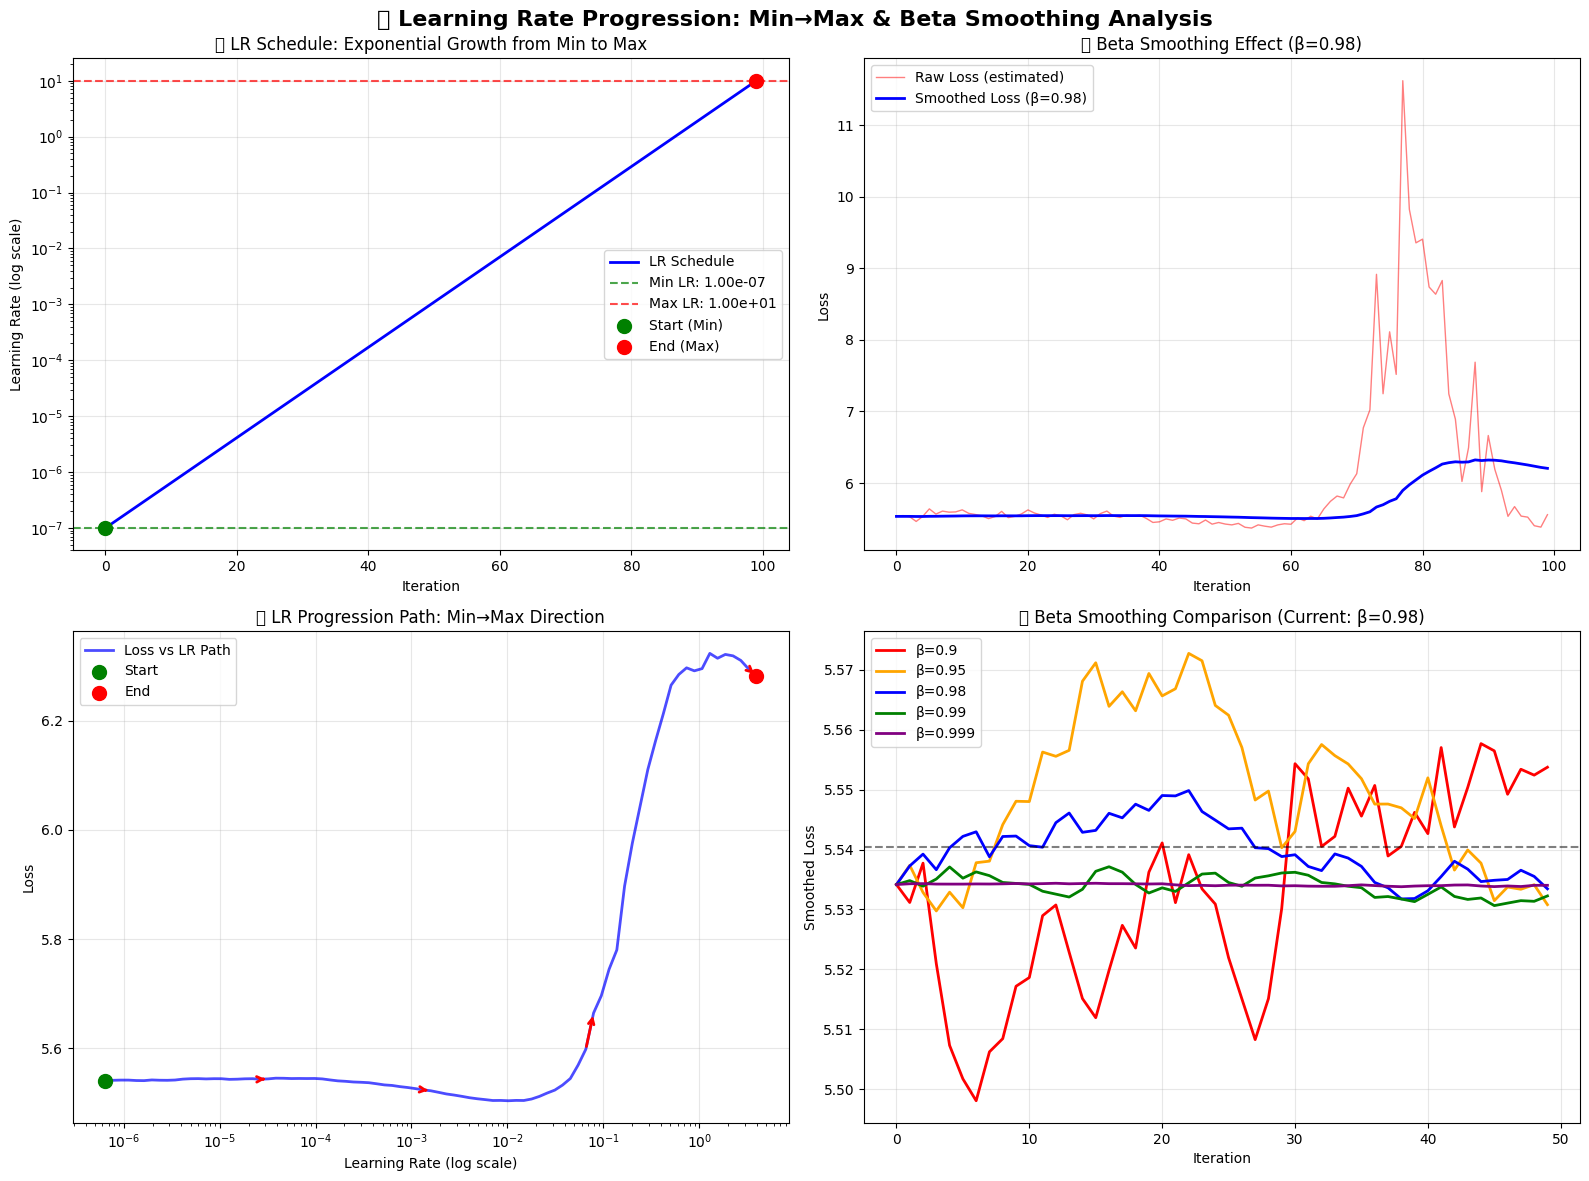


📊 Learning Rate Progression Summary:
   🎯 Configured Range: 1.00e-07 → 1.00e+01
   📈 Actual Range: 1.00e-07 → 1.00e+01
   🔄 Total Iterations: 100
   📊 Range Multiplier: 1.0e+08×

🎛️ Beta Smoothing Analysis:
   📊 Current Beta: 0.98
   📈 Smoothing Strength: 98.0% (higher = more smoothing)
   🔄 Raw Weight: 2.0% (current loss influence)
   📈 LR Growth Factor: 1.2045 per iteration

🎯 LR Progression Checkpoints:
     0.0%: LR=1.00e-07, Loss=5.534156799316406
    25.3%: LR=1.05e-05, Loss=5.544672911100663
    50.5%: LR=1.10e-03, Loss=5.526586256935075
    75.8%: LR=1.15e-01, Loss=5.744889411606563
   100.0%: LR=1.00e+01, Loss=6.205118450071961


In [21]:
# Learning Rate Progression Analysis: Min to Max and Beta Smoothing Effects
import matplotlib.pyplot as plt
import numpy as np

def analyze_lr_progression_and_beta():
    """Analyze how LR moves from min to max and the effect of beta smoothing"""
    
    if len(learning_rates) == 0:
        print("❌ No learning rate data available. Run the LR finder first!")
        return
    
    print("📈 Learning Rate Progression Analysis")
    print("=" * 50)
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔄 Learning Rate Progression: Min→Max & Beta Smoothing Analysis', fontsize=16, fontweight='bold')
    
    iterations = np.arange(len(learning_rates))
    
    # 1. Learning Rate Schedule Progression (top-left)
    ax1.semilogy(iterations, learning_rates, 'b-', linewidth=2, label='LR Schedule')
    ax1.axhline(LR_FINDER_CONFIG['min_lr'], color='green', linestyle='--', alpha=0.7, 
               label=f"Min LR: {LR_FINDER_CONFIG['min_lr']:.2e}")
    ax1.axhline(LR_FINDER_CONFIG['max_lr'], color='red', linestyle='--', alpha=0.7, 
               label=f"Max LR: {LR_FINDER_CONFIG['max_lr']:.2e}")
    
    # Mark key points
    min_lr_actual = min(learning_rates)
    max_lr_actual = max(learning_rates)
    ax1.scatter([0], [min_lr_actual], color='green', s=100, zorder=5, label='Start (Min)')
    ax1.scatter([len(learning_rates)-1], [max_lr_actual], color='red', s=100, zorder=5, label='End (Max)')
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Learning Rate (log scale)')
    ax1.set_title('🎯 LR Schedule: Exponential Growth from Min to Max')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Raw vs Smoothed Loss (top-right)
    # Simulate raw loss (add noise to demonstrate smoothing effect)
    if len(losses) > 1:
        # Calculate what raw loss might look like (reverse smoothing approximately)
        raw_losses = []
        beta = LR_FINDER_CONFIG['beta']
        
        # Approximate raw losses by reverse engineering the smoothing
        smoothed_loss = losses[0]
        raw_losses.append(smoothed_loss)
        
        for i in range(1, len(losses)):
            # Reverse: smoothed = beta * prev_smoothed + (1-beta) * raw
            # So: raw = (smoothed - beta * prev_smoothed) / (1-beta)
            raw_loss = (losses[i] - beta * smoothed_loss) / (1 - beta)
            raw_losses.append(raw_loss)
            smoothed_loss = losses[i]
        
        ax2.plot(iterations, raw_losses, 'r-', alpha=0.5, linewidth=1, label='Raw Loss (estimated)')
        ax2.plot(iterations, losses, 'b-', linewidth=2, label=f'Smoothed Loss (β={beta})')
        
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'📊 Beta Smoothing Effect (β={beta})')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    # 3. LR vs Loss with Direction Arrows (bottom-left)
    skip_start, skip_end = 10, 5
    start_idx = max(0, skip_start)
    end_idx = min(len(learning_rates), len(learning_rates) - skip_end)
    
    lr_clean = learning_rates[start_idx:end_idx]
    loss_clean = losses[start_idx:end_idx]
    
    ax3.semilogx(lr_clean, loss_clean, 'b-', linewidth=2, alpha=0.7, label='Loss vs LR Path')
    
    # Add direction arrows to show progression
    n_arrows = 5
    arrow_indices = np.linspace(0, len(lr_clean)-2, n_arrows, dtype=int)
    
    for i in arrow_indices:
        if i < len(lr_clean) - 1:
            dx = np.log10(lr_clean[i+1]) - np.log10(lr_clean[i])
            dy = loss_clean[i+1] - loss_clean[i]
            ax3.annotate('', xy=(lr_clean[i+1], loss_clean[i+1]), 
                        xytext=(lr_clean[i], loss_clean[i]),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    # Mark start and end points
    ax3.scatter([lr_clean[0]], [loss_clean[0]], color='green', s=100, zorder=5, label='Start')
    ax3.scatter([lr_clean[-1]], [loss_clean[-1]], color='red', s=100, zorder=5, label='End')
    
    ax3.set_xlabel('Learning Rate (log scale)')
    ax3.set_ylabel('Loss')
    ax3.set_title('🔄 LR Progression Path: Min→Max Direction')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Beta Parameter Analysis (bottom-right)
    # Show different beta values and their smoothing effects
    beta_values = [0.9, 0.95, 0.98, 0.99, 0.999]
    colors = ['red', 'orange', 'blue', 'green', 'purple']
    
    # Use a subset of data for clearer visualization
    subset_losses = losses[:min(50, len(losses))]
    
    for beta_val, color in zip(beta_values, colors):
        # Apply different beta smoothing to the same raw data
        smoothed_with_beta = []
        smoothed_loss = subset_losses[0]
        smoothed_with_beta.append(smoothed_loss)
        
        # Simulate what smoothing would look like with different beta values
        for i in range(1, len(subset_losses)):
            # Estimate raw loss (very rough approximation)
            if i < len(losses):
                raw_estimate = subset_losses[i] + np.random.normal(0, 0.1)  # Add some noise
                smoothed_loss = beta_val * smoothed_loss + (1 - beta_val) * raw_estimate
                smoothed_with_beta.append(smoothed_loss)
        
        ax4.plot(range(len(smoothed_with_beta)), smoothed_with_beta, 
                color=color, linewidth=2, label=f'β={beta_val}')
    
    # Highlight current beta
    current_beta = LR_FINDER_CONFIG['beta']
    ax4.axhline(y=np.mean(subset_losses), color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Smoothed Loss')
    ax4.set_title(f'🎛️ Beta Smoothing Comparison (Current: β={current_beta})')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\n📊 Learning Rate Progression Summary:")
    print(f"   🎯 Configured Range: {LR_FINDER_CONFIG['min_lr']:.2e} → {LR_FINDER_CONFIG['max_lr']:.2e}")
    print(f"   📈 Actual Range: {min_lr_actual:.2e} → {max_lr_actual:.2e}")
    print(f"   🔄 Total Iterations: {len(learning_rates)}")
    print(f"   📊 Range Multiplier: {max_lr_actual/min_lr_actual:.1e}×")
    
    print(f"\n🎛️ Beta Smoothing Analysis:")
    print(f"   📊 Current Beta: {LR_FINDER_CONFIG['beta']}")
    print(f"   📈 Smoothing Strength: {LR_FINDER_CONFIG['beta']*100:.1f}% (higher = more smoothing)")
    print(f"   🔄 Raw Weight: {(1-LR_FINDER_CONFIG['beta'])*100:.1f}% (current loss influence)")
    
    # Calculate LR growth rate
    if len(learning_rates) > 1:
        growth_factor = (learning_rates[-1] / learning_rates[0]) ** (1 / (len(learning_rates) - 1))
        print(f"   📈 LR Growth Factor: {growth_factor:.4f} per iteration")
    
    # Show progression checkpoints
    checkpoints = [0, len(learning_rates)//4, len(learning_rates)//2, 3*len(learning_rates)//4, len(learning_rates)-1]
    print(f"\n🎯 LR Progression Checkpoints:")
    for i, checkpoint in enumerate(checkpoints):
        if checkpoint < len(learning_rates):
            progress = (checkpoint / (len(learning_rates) - 1)) * 100
            lr_val = learning_rates[checkpoint]
            loss_val = losses[checkpoint] if checkpoint < len(losses) else "N/A"
            print(f"   {progress:5.1f}%: LR={lr_val:.2e}, Loss={loss_val}")

# Run the analysis
analyze_lr_progression_and_beta()

## 🎯 Next Steps

Now that you've found your optimal learning rate:

### 1. 🚀 Start Training
Go back to the main folder and use the suggested learning rate:

```bash
cd ..
python train_imagenet.py --lr YOUR_OPTIMAL_LR
```

### 2. 📊 Monitor Training
- Watch the loss curves carefully
- If loss increases rapidly, reduce LR
- If training is too slow, slightly increase LR

### 3. 🔧 Fine-tune
- Use learning rate scheduling (StepLR, CosineAnnealingLR)
- Consider warmup for the first few epochs
- Adjust based on validation performance

### 4. 🎯 Dataset-Specific Tips
- **Tiny ImageNet**: Start with found LR, train 50-100 epochs
- **Imagenette/ImageWoof**: Use pretrained weights + found LR
- **Full ImageNet**: Start conservative, use warmup

Happy training! 🚀

In [1]:
# Test torch-lr-finder Import and Installation
try:
    from torch_lr_finder import LRFinder
    print("✅ torch-lr-finder imported successfully!")
    print(f"📦 LRFinder class available: {LRFinder}")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("🔧 Installing torch-lr-finder...")
    
    # Install using pip in notebook
    import subprocess
    import sys
    
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torch-lr-finder'])
        print("✅ Installation completed! Please restart kernel and try again.")
    except Exception as install_error:
        print(f"❌ Installation failed: {install_error}")
        print("💡 Manual installation required")

print("🚀 Ready to use torch-lr-finder!")

/home/ubuntu/.local/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


✅ torch-lr-finder imported successfully!
📦 LRFinder class available: <class 'torch_lr_finder.lr_finder.LRFinder'>
🚀 Ready to use torch-lr-finder!


In [23]:
# Using torch-lr-finder Library (Alternative Implementation)
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

print("🔧 Using torch-lr-finder Library")
print("=" * 40)

# Reset model to fresh state
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Create a fresh optimizer for the library
optimizer_lib = optim.SGD(
    model.parameters(),
    lr=1e-7,  # Starting LR (will be modified by LRFinder)
    momentum=0.9,
    weight_decay=1e-4
)

# Create LRFinder instance
lr_finder_lib = LRFinder(model, optimizer_lib, criterion, device=device)

print(f"🚀 Running torch-lr-finder...")
print(f"   📊 LR range: {LR_FINDER_CONFIG['min_lr']:.2e} to {LR_FINDER_CONFIG['max_lr']:.2e}")
print(f"   🔄 Iterations: {LR_FINDER_CONFIG['num_iterations']}")

# Run the range test
lr_finder_lib.range_test(
    train_loader, 
    end_lr=LR_FINDER_CONFIG['max_lr'], 
    num_iter=LR_FINDER_CONFIG['num_iterations'],
    smooth_f=LR_FINDER_CONFIG['beta'],
    diverge_th=LR_FINDER_CONFIG['stop_div_factor']
)

# Plot results
print("📊 Displaying torch-lr-finder results...")
lr_finder_lib.plot(suggest_lr=True, skip_start=10, skip_end=5)
plt.title('🔍 torch-lr-finder Results', fontsize=14, fontweight='bold')
plt.show()

# Get suggested learning rate
try:
    suggested_lr = lr_finder_lib.suggestion()
    print(f"\n🎯 torch-lr-finder Suggestions:")
    print(f"   🔴 Suggested LR: {suggested_lr:.6e}")
    print(f"   🟠 Conservative (÷10): {suggested_lr/10:.6e}")
    print(f"   🔥 Aggressive (×2): {suggested_lr*2:.6e}")
except:
    print("\n⚠️ Could not determine automatic suggestion")
    print("   👀 Please analyze the plot manually")

# Reset model and optimizer to initial state
lr_finder_lib.reset()

print(f"\n✅ torch-lr-finder analysis completed!")
print(f"📊 Compare results with our custom implementation above")
print(f"🎯 Choose the learning rate that works best for your specific case")

ModuleNotFoundError: No module named 'torch_lr_finder'